In [43]:
#Importing Libraries
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import average_precision_score
from sklearn.ensemble import AdaBoostClassifier as ab
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

import sys
import subprocess
import pkg_resources
from collections import Counter
import re
from numpy import log, mean



In [44]:
#Importing training dataset and storing it in a dataframe names "trainMovie_df"
trainMovie_df = pd.read_excel('/content/Training_sheet.xlsx')
'''Getting the shape of the DataFrame'''
print(trainMovie_df.shape)
trainMovie_df.head()

(1196, 15)


,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


In [45]:
#Importing the scoring sheet for prediction and storing it in a dataframe names "testMovie_df"
testMovie_df = pd.read_excel('/content/Scoring_Sheet.xlsx')
'''Getting the shape of the DataFrame'''
print(testMovie_df.shape)
testMovie_df.head()

(91, 14)


,id,name,display_name,production_budget,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name
0,7970115,"Avengers, The (2011)",Marvel's The Avengers,225000000,2012,0,Super Hero,Based on Comic/Graphic Novel,Live Action,Adventure,English,for intense sequences of sci-fi violence and a...,PG-13,Wide
1,174540115,Dark Knight Rises The,The Dark Knight Rises,0,2012,1,Super Hero,Based on Comic/Graphic Novel,Live Action,Action,English,"for intense sequences of violence and action, ...",PG-13,Wide
2,149080115,Bond 23,Skyfall,200000000,2012,1,Contemporary Fiction,Based on Fiction Book/Short Story,Live Action,Action,English,"for intense violent sequences throughout, some...",PG-13,Wide
3,136020115,Twilight Saga Breaking Dawn Part 2 The,"The Twilight Saga: Breaking Dawn, Part 2",136200000,2012,1,Fantasy,Based on Fiction Book/Short Story,Live Action,Drama,English,for sequences of violence including disturbing...,PG-13,Wide
4,53500115,"Hobbit, The",The Hobbit: An Unexpected Journey,270000000,2012,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for extended sequences of intense fantasy acti...,PG-13,Wide


# Exploratory Data Analysis

After reading the csv files, I am doing some initial exploration on the dataset to get the structure of data. Then, I will do some data cleaning and feature engineering(if needed) to understand and get some insights about the dataset.

In [46]:
#checking null values in the train movie dataset
print("null values in training movie data\n",trainMovie_df.isnull().sum())

#checking null values in the test movie dataset
print("null values in testing movie data\n",testMovie_df.isnull().sum())

null values in training movie data
 id                                    0
name                                  0
display_name                          0
production_year                       0
movie_sequel                          0
creative_type                         0
source                                0
production_method                     0
genre                                 0
language                              0
board_rating_reason                   0
movie_board_rating_display_name       0
movie_release_pattern_display_name    0
total                                 0
Category                              0
dtype: int64
null values in testing movie data
 id                                    0
name                                  0
display_name                          0
production_budget                     0
production_year                       0
movie_sequel                          0
creative_type                         0
source                              

In [47]:
#getting column names of train movie dataset and test movie data set since dimensions of train and test dataset is different
print("training dataset columns:",list(trainMovie_df.columns))
print("testing dataset columns:",list(testMovie_df.columns))

training dataset columns: ['id', 'name', 'display_name', 'production_year', 'movie_sequel', 'creative_type', 'source', 'production_method', 'genre', 'language', 'board_rating_reason', 'movie_board_rating_display_name', 'movie_release_pattern_display_name', 'total', 'Category']
testing dataset columns: ['id', 'name', 'display_name', 'production_budget', 'production_year', 'movie_sequel', 'creative_type', 'source', 'production_method', 'genre', 'language', 'board_rating_reason', 'movie_board_rating_display_name', 'movie_release_pattern_display_name']


Production budget is the extra columns that is present in test data but not in train data. Similarly, total and category are not present in test data but present in train data which is the prediction label.

In [48]:
#Number of numericals features in train movie dataset
numerical_feature = [feature for feature in trainMovie_df.columns if trainMovie_df[feature].dtype != 'O']  
print('Number of numerical variables:', len(numerical_feature)) 
numerical_feature

Number of numerical variables: 5


['id', 'production_year', 'movie_sequel', 'total', 'Category']

In [49]:
#categorical feature in train movie dataset
categorical_feature = [feature for feature in trainMovie_df.columns if trainMovie_df[feature].dtype == 'O']  
print('Number of categorical variables:', len(categorical_feature))  
categorical_feature

Number of categorical variables: 10


['name',
 'display_name',
 'creative_type',
 'source',
 'production_method',
 'genre',
 'language',
 'board_rating_reason',
 'movie_board_rating_display_name',
 'movie_release_pattern_display_name']

In [50]:
#number of categories in each feature in training dataset
for feature in categorical_feature:
    print('The feature is {} and number of categories are {}'.format(feature, len(trainMovie_df[feature].unique())))

The feature is name and number of categories are 1196
The feature is display_name and number of categories are 1195
The feature is creative_type and number of categories are 9
The feature is source and number of categories are 16
The feature is production_method and number of categories are 6
The feature is genre and number of categories are 13
The feature is language and number of categories are 16
The feature is board_rating_reason and number of categories are 1003
The feature is movie_board_rating_display_name and number of categories are 6
The feature is movie_release_pattern_display_name and number of categories are 7


In [51]:
for feature in categorical_feature:
    print('The feature is {} and number of categories are {}'.format(feature, len(testMovie_df[feature].unique())))

The feature is name and number of categories are 91
The feature is display_name and number of categories are 91
The feature is creative_type and number of categories are 8
The feature is source and number of categories are 10
The feature is production_method and number of categories are 3
The feature is genre and number of categories are 9
The feature is language and number of categories are 5
The feature is board_rating_reason and number of categories are 79
The feature is movie_board_rating_display_name and number of categories are 5
The feature is movie_release_pattern_display_name and number of categories are 6


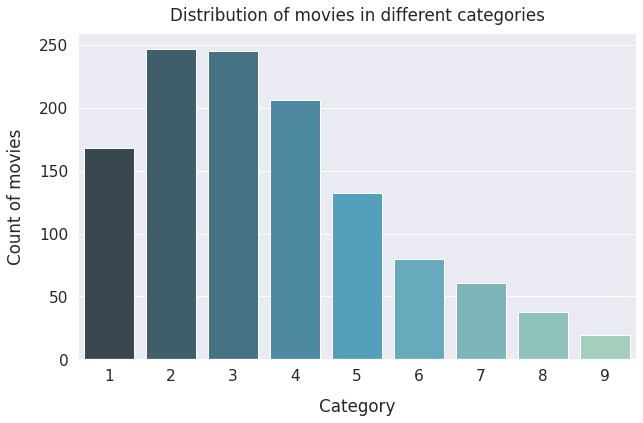

In [52]:
#Count of the movies in each category
plt.figure(figsize=(10,6))
sns.set(font_scale=1.4)
stat_category = trainMovie_df['Category'].value_counts()
bar_plot = sns.barplot(x = stat_category.index, y = stat_category.values,palette="GnBu_d")
sns.set_style("white")
plt.xlabel("Category", labelpad=14)
plt.ylabel("Count of movies", labelpad=14)
plt.title("Distribution of movies in different categories", y=1.02);

The number of movies in each category is unbalanced with very high number of movies for 2 and 3 category and very less number of movies for 8 and 9. It is highly unbalanced data.

Text(0, 0.5, 'Gross total')

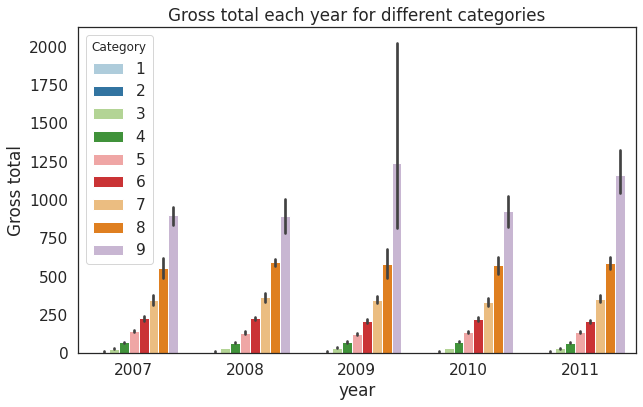

In [53]:
#Plot of total and the number movies produced each year
stat_production_year = trainMovie_df['production_year']
stat_total = trainMovie_df['total']
plt.figure(figsize=(10,6))
bar_sector = sns.barplot(x= stat_production_year, y=stat_total, hue="Category",palette="Paired", data=trainMovie_df)
sns.set_style("white")
plt.title('Gross total each year for different categories')
plt.xlabel('year')
plt.ylabel('Gross total')

With each year, the total has been been increasing and the highest gross total has always been for Category 9.

Text(0, 0.5, 'Number of movies produced')

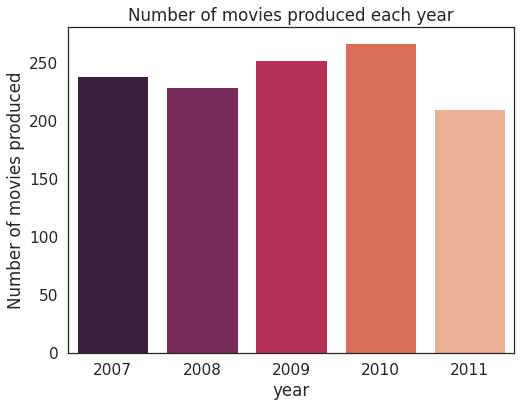

In [56]:
#Plot of the number movies produced each year
stat_production_year = trainMovie_df['production_year'].value_counts()
plt.figure(figsize=(8,6))
bar_sector = sns.barplot(x = stat_production_year.index, y = stat_production_year.values,palette="rocket")
sns.set_style("white")
plt.title('Number of movies produced each year')
plt.xlabel('year')
plt.ylabel('Number of movies produced')

From the above figure we can observe, each year around 200-275 movies have been released.

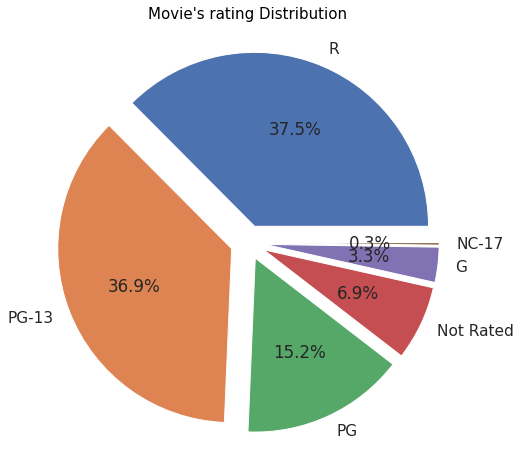

In [57]:
#Distribution of different ratings using a pie chart
stat_genre = trainMovie_df['movie_board_rating_display_name'].value_counts()
explode = [0.1,0.1,0.1,0.1,0.1,0.1]
plt.figure(figsize = (8,8))
plt.pie(stat_genre.values, labels=stat_genre.index, explode=explode, autopct='%1.1f%%')
plt.title('Movie\'s rating Distribution',color = 'Black',fontsize = 15)

plt.show()

Most of the movies belong to PG-13 class and R class and very less percentage of movies needs no restrictions.

Text(0.5, 1.0, 'Distribution of movies with/without Sequel')

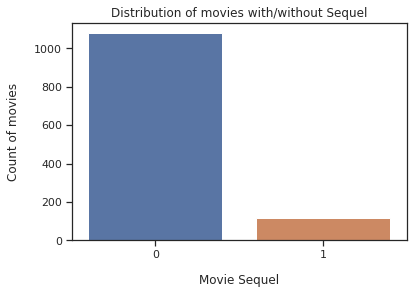

In [58]:
#distribution of the number of movies with sequel and without sequel.
sns.set(style="ticks", color_codes=True)
stat_movie_sequel = trainMovie_df['movie_sequel'].value_counts()
sns.barplot(x= stat_movie_sequel.index, y=stat_movie_sequel.values)
plt.xlabel("Movie Sequel", labelpad=14)
plt.ylabel("Count of movies", labelpad=14)
plt.title("Distribution of movies with/without Sequel")

From the above figure, we can see that there are very few movies with sequel and a lot of movies with no sequel.

Text(0.5, 1.0, 'Distribution of gross total earnings in different production method')

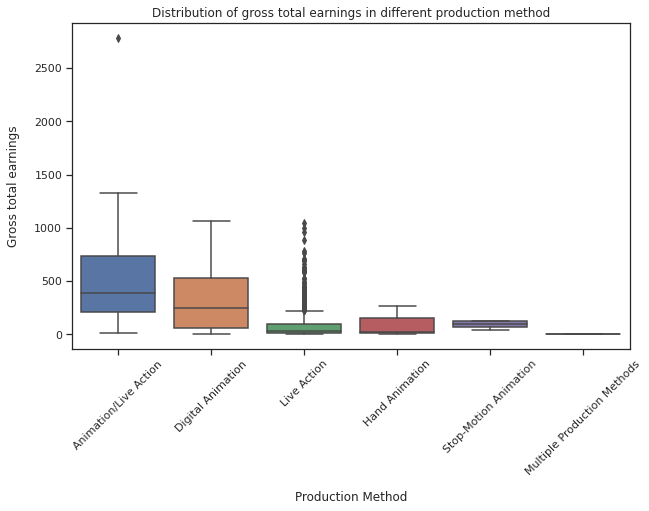

In [59]:
#Distribution of gross total earnings in different production method.
plt.figure(figsize=(10,6))
chart = sns.boxplot(x="production_method", y="total", data=trainMovie_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
plt.xlabel("Production Method", labelpad=14)
plt.ylabel("Gross total earnings", labelpad=14)
plt.title("Distribution of gross total earnings in different production method")

Animation/live Action is the most liked method in movies with highest gross total earnings. Most of the movies use different kind of animations. There's one movie under Animation/Live Action category which has the exceeded the Animation/Live Action category and acting as an outlier with gross total earning of 2784 million dollars.

Text(0.5, 1.0, 'Distribution of gross total earnings in different creative type')

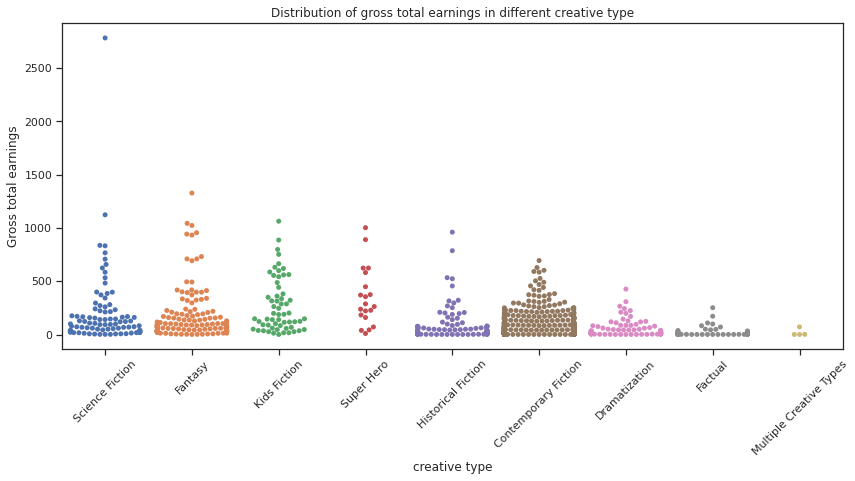

In [16]:
#Distribution of gross total of earnings of movies with different creation type 
plt.figure(figsize=(14,6))
chart = sns.swarmplot(x="creative_type", y="total", data=trainMovie_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
plt.xlabel("creative type")
plt.ylabel("Gross total earnings")
plt.title("Distribution of gross total earnings in different creative type")

Most of the different creative types movies have earing below 500 million dollars and a few have exceeded this values and there is one movie which has extremely exceeded this values and is under the category of Science Fiction with total earning of 2784 million dollars.

Text(0.5, 1.0, 'Distribution of Gross total earnings with different languages movies')

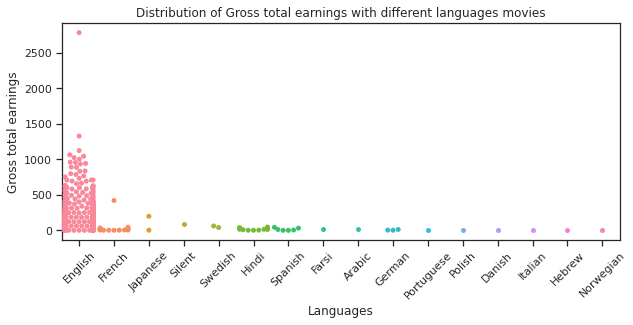

In [17]:
#Distribution of Gross total earnings with different languages movies
plt.figure(figsize=(10,4))
chart = sns.swarmplot(x="language", y="total", data=trainMovie_df)
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
plt.xlabel("Languages")
plt.ylabel("Gross total earnings")
plt.title("Distribution of Gross total earnings with different languages movies")

Most of the movies are in english language with the most gross total earnings. Just a handful of movies in other languages are there.

Text(0.5, 1.0, 'Distribution of Gross total earnings of movies in different genres')

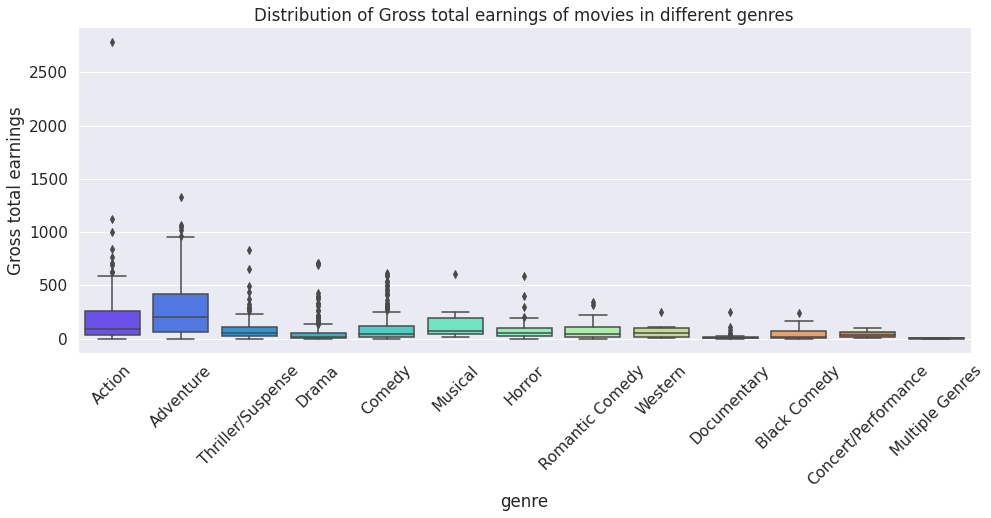

In [18]:
#Distribution of Gross total earnings of movies in different genres
plt.figure(figsize=(16,6))
sns.set(font_scale=1.4)
chart = sns.boxplot(x='genre',y='total',data=trainMovie_df,palette='rainbow')
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
plt.xlabel("genre")
plt.ylabel("Gross total earnings")
plt.title("Distribution of Gross total earnings of movies in different genres")

Most of movies in Genre Action, Adventure, Thriller, Drama, Comedy have more gross total earnings that tells the spectators liking towards movies with different kind of emotions.

Text(0.5, 1.0, 'Distribution of Gross total earnings of movies from different sources')

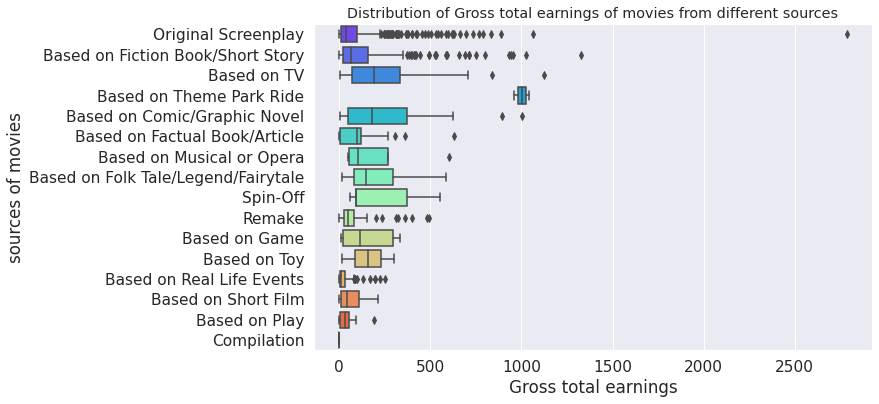

In [19]:
#Distribution of Gross total earnings of movies in different sources
plt.figure(figsize=(10,6))
chart = sns.boxplot(x='total',y='source',data=trainMovie_df,palette='rainbow')
sns.set(font_scale=1.2)
plt.ylabel("sources of movies")
plt.xlabel("Gross total earnings")
plt.title("Distribution of Gross total earnings of movies from different sources")

From this plot, it can be infered that most of the movies with highest gross total earning are based on Original Screenplay, Based on Fiction Book,or based on TV. There are very few movies based on the theme park ride, but have earned around 1000 million dollars of gross total earnings. 

#model 1.0 (Basic Model)

In the basic, I am dropping features such as **id, name** and **display_name** from the training data as they are not giving much information about the response and there are too many categories in them, using one-hot encoding would for such feature would result in too many features in the model and that won't add any value as well and the model may overfit. 

Since, the number of categories are different for train and test dataset for features such as **'creative_type', 'source', 'production_method', 'genre', 'language',  'movie_board_rating_display_name', 'movie_release_pattern_display_name'**, combining both train and test data frames and getting the one-hot encoding will ensure consistency after spliting this combined matrix back into train and test dataset.

In the basic model **"Board_Rating_reason"** column has been dropped and then the model prediction has been performed. 

**Approach** - Keeping the above points in mind, opting for predicting the category directly without taking "total" into model sounded a better approach and more generalized approach for an attempt to use similar kind of model for bollywood industry. The reason being the category distribution on the basis of ranges in total is defined for hollywood movies and as the http://www1.mmo.org.tr/resimler/dosya_ekler/c5b45ddb3ff1f62_ek.pdf paper suggests these ranges are determined based on the information and in-depth advice obtained from several industry experts(decision makers) in Hollywood, we do not have that kind of information for this data.Thus, dropping "total" and predicting "Category" is the approach. Thus, in the basic model, three classification algorithms(Decision Tree, Random Forest, Adaboost) performance has been compared using the training accuracy, cross-validation accuracy and prediction is made for the test data.

**Good Failure** - As we are making a prediction model, the ideal type of implementation was to predict the **"total"** feature which gives the gross total earnings from the movies and classify the movies into the 9 categories according to their gross total. In this case study, the most of the features are categorical and only **"total"** and **"category"** highly corelated and less correlation with other features. As a result, Regression techniques were giving very high amount of error. Also the range of distribution of categories is also unknown to classify the movies into different Categories on the basis of "total". 



In [60]:
#Target variable to be predicted
Category_label = trainMovie_df['Category']

In [61]:
#Ensuring the number of classes in train and test set are equal and number of features are equal after onehot encoding
trainData = trainMovie_df.loc[:, ['creative_type','source','production_method','genre','language','movie_board_rating_display_name','movie_release_pattern_display_name']]
testData = testMovie_df.loc[:, ['creative_type','source','production_method','genre','language','movie_board_rating_display_name','movie_release_pattern_display_name']]

trainData_len = len(trainData)

CombinedDf = pd.concat(objs=[trainData, testData], axis=0)
CombinedDf.head()

,creative_type,source,production_method,genre,language,movie_board_rating_display_name,movie_release_pattern_display_name
0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,PG-13,Wide
1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,PG-13,Wide
2,Science Fiction,Based on TV,Animation/Live Action,Action,English,PG-13,Wide
3,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,G,Wide
4,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,PG-13,Wide


In [62]:
#One-hot encoding the categorical variables for training dataset
CombinedDf = pd.get_dummies(CombinedDf, columns=['creative_type','source','production_method','genre','language','movie_board_rating_display_name','movie_release_pattern_display_name'])            

In [63]:
#Splitting both Dataframe after ensuring same number of features after one hot encoding of categorical variables
trainData = CombinedDf[:trainData_len]
testData = CombinedDf[trainData_len:]

In [64]:
#Joining the one-hot encoded dataframe the actual dataframe
trainMovie_df_new = trainMovie_df.loc[:, ['production_year','movie_sequel']].join(trainData)
testMovie_df_new = testMovie_df.loc[:, ['production_year','movie_sequel']].join(testData)

In [65]:
#function for prediction 
def prediction(trainMovie_df_new,Category_label,testMovie_df_new,pred_model,cv):
  '''Model prediction'''
  model = pred_model
  cv_score = cross_val_score(model, trainMovie_df_new, Category_label, cv=cv)
  model.fit(trainMovie_df_new, Category_label)
  train_predictions = model.predict(trainMovie_df_new)
  test_predictions = model.predict(testMovie_df_new)
  score = model.score(trainMovie_df_new,Category_label)
  print("Cross-validation Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))
  print("-----------------------------------------------------------------------------------------------------")
  print("test category labels:")
  print(test_predictions)

  print("-----------------------------------------------------------------------------------------------------")

  '''plotting learning curve'''
  print("Learning curve of training score and cross-validated score:")
  train_sizes, train_scores, test_scores = learning_curve(model, 
                                                          trainMovie_df_new, 
                                                          Category_label,
                                                          cv = 6,
                                                          scoring='accuracy',
                                                          train_sizes=np.linspace(0.01, 1.0, 50))

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)
  plt.figure(figsize=(6,4))
  plt.plot(train_sizes, train_mean, '--', color="g",  label="Training score")
  plt.plot(train_sizes, test_mean, color="r", label="Cross-validation score")

  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  plt.title("Learning Curve")
  plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()

  print("-----------------------------------------------------------------------------------------------------")
  print("Confusion matrix of training data:")
  cm = confusion_matrix(Category_label, train_predictions)
  sns.set(font_scale=1)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'YlOrRd',xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9]
              ,yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9]);
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(round(score,4))
  plt.title(all_sample_title)
  plt.show()

  print("-----------------------------------------------------------------------------------------------------")
  print("Classification report with precision, recall, F1-score of each class:")
  '''to print classification report'''
  print(classification_report(Category_label, model.predict(trainMovie_df_new)))

  return train_predictions,test_predictions,score


### Prediction using Decision Tree

Cross-validation Accuracy: 0.26 (+/- 0.04)
-----------------------------------------------------------------------------------------------------
test category labels:
[7 7 8 8 9 9 5 8 5 8 4 4 3 5 4 3 4 9 4 4 7 4 4 4 4 3 4 5 4 4 1 5 3 4 4 1 1
 4 4 3 4 4 3 1 4 2 1 4 1 4 1 4 2 4 3 4 1 4 4 2 2 1 2 2 1 8 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1]
-----------------------------------------------------------------------------------------------------
Learning curve of training score and cross-validated score:


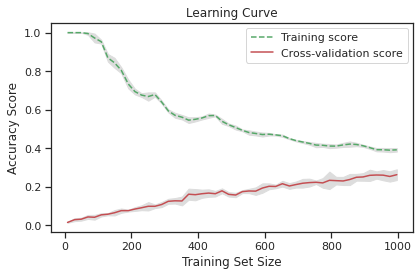

-----------------------------------------------------------------------------------------------------
Confusion matrix of training data:


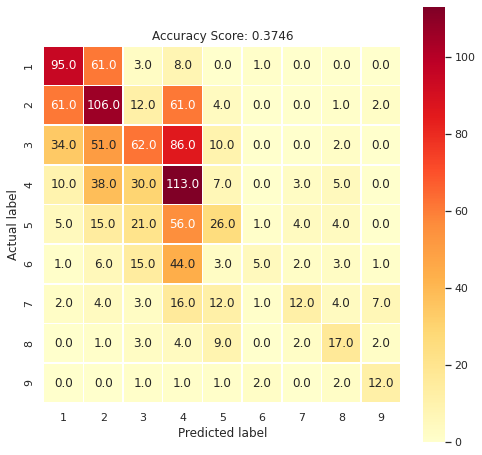

-----------------------------------------------------------------------------------------------------
Classification report with precision, recall, F1-score of each class:
              precision    recall  f1-score   support

           1       0.46      0.57      0.51       168
           2       0.38      0.43      0.40       247
           3       0.41      0.25      0.31       245
           4       0.29      0.55      0.38       206
           5       0.36      0.20      0.25       132
           6       0.50      0.06      0.11        80
           7       0.52      0.20      0.29        61
           8       0.45      0.45      0.45        38
           9       0.50      0.63      0.56        19

    accuracy                           0.37      1196
   macro avg       0.43      0.37      0.36      1196
weighted avg       0.40      0.37      0.36      1196



In [66]:
train_predictions,test_predictions,score = prediction(trainMovie_df_new,Category_label,testMovie_df_new,dt(criterion="entropy",max_depth=10,max_leaf_nodes=50),6)

Inference: after trying different clssifiers such as Logistic regression, SVC, Naive Bayes and ensemble methods. Decision Tree, Random Forest and Adaboost gave considerable results. 

In the above model 1.0, I am using decision tree as a classifier with criterion as entropy, max_depth of the trees to be 10 and k for cross-validation to be 6. The values of k as 6 gave the best results for Decision Tree and Random Forest. Since the data is less, decision tree over-fits as we increase the max depth thus, I have kept it as 10. I have limited the number of leaf to 50. The cross-validation accuracy is coming out to be 26%.

### Prediction using Random Forest

Cross-validation Accuracy: 0.28 (+/- 0.04)
-----------------------------------------------------------------------------------------------------
test category labels:
[3 7 4 4 9 7 8 8 8 8 4 4 4 5 3 3 4 9 3 3 4 4 2 3 4 4 4 5 4 3 1 4 3 3 3 1 1
 3 2 3 4 3 4 1 3 1 2 3 2 3 1 3 1 4 2 3 2 4 2 2 2 2 2 2 1 4 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1]
-----------------------------------------------------------------------------------------------------
Learning curve of training score and cross-validated score:


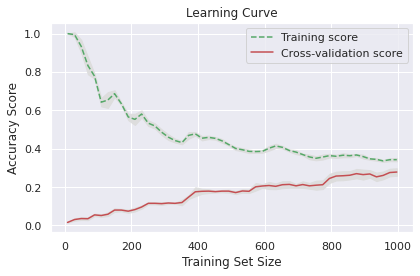

-----------------------------------------------------------------------------------------------------
Confusion matrix of training data:


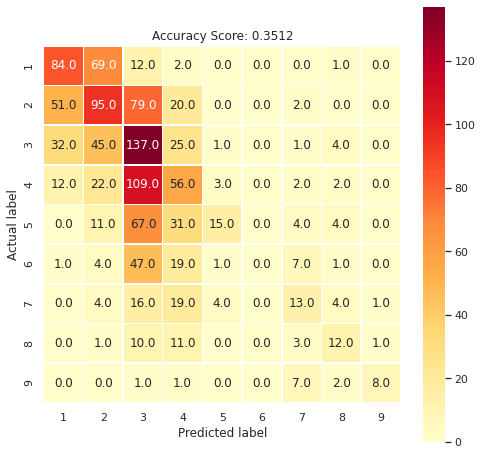

-----------------------------------------------------------------------------------------------------
Classification report with precision, recall, F1-score of each class:
              precision    recall  f1-score   support

           1       0.47      0.50      0.48       168
           2       0.38      0.38      0.38       247
           3       0.29      0.56      0.38       245
           4       0.30      0.27      0.29       206
           5       0.62      0.11      0.19       132
           6       0.00      0.00      0.00        80
           7       0.33      0.21      0.26        61
           8       0.40      0.32      0.35        38
           9       0.80      0.42      0.55        19

    accuracy                           0.35      1196
   macro avg       0.40      0.31      0.32      1196
weighted avg       0.37      0.35      0.33      1196



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
train_predictions,test_predictions,score = prediction(trainMovie_df_new,Category_label,testMovie_df_new,RF(criterion="entropy",max_depth=10, max_leaf_nodes=10),6)

Inference: In the above part I have used Random-forest algorithm which uses ensemble of trees to reduce overfitting and improve the performance of the model. In the above model I have taken a k values of 6 for cross-validation, criterion as "entropy",max_depth to be 10 and when I decreased the number of leaves to 10, the gap between the training accuracy and cross-validation accuracy decreased a lot. Thus, the training accuracy is coming out to be 35.1% and the k fold cross-validation accuracy is coming out to be 28% which is much better than decision tree.

### Prediction using Ensemble Learning - Adaboost

Cross-validation Accuracy: 0.28 (+/- 0.09)
-----------------------------------------------------------------------------------------------------
test category labels:
[6 7 7 5 8 7 5 8 5 8 3 3 5 5 3 3 7 8 4 3 5 3 2 4 5 5 3 5 3 3 2 9 3 3 3 2 2
 3 3 3 5 3 5 2 3 2 2 3 2 3 2 3 2 3 2 3 2 3 3 2 2 2 1 2 2 5 2 1 1 2 1 1 2 2
 6 1 2 1 2 2 1 2 1 2 2 1 2 2 2 2 1]
-----------------------------------------------------------------------------------------------------
Learning curve of training score and cross-validated score:


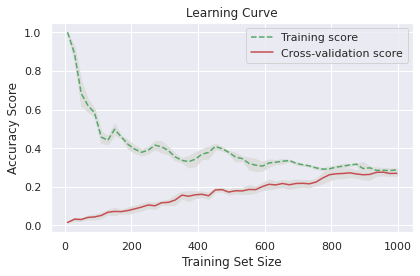

-----------------------------------------------------------------------------------------------------
Confusion matrix of training data:


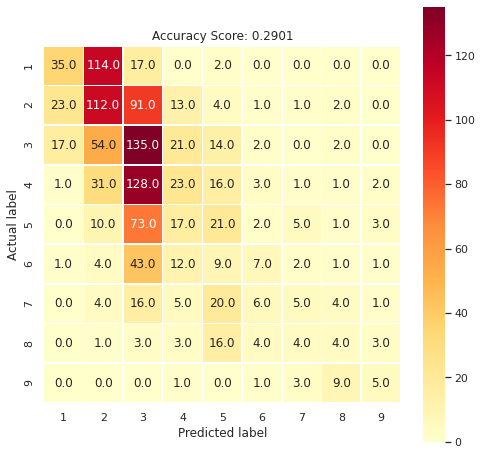

-----------------------------------------------------------------------------------------------------
Classification report with precision, recall, F1-score of each class:
              precision    recall  f1-score   support

           1       0.45      0.21      0.29       168
           2       0.34      0.45      0.39       247
           3       0.27      0.55      0.36       245
           4       0.24      0.11      0.15       206
           5       0.21      0.16      0.18       132
           6       0.27      0.09      0.13        80
           7       0.24      0.08      0.12        61
           8       0.17      0.11      0.13        38
           9       0.33      0.26      0.29        19

    accuracy                           0.29      1196
   macro avg       0.28      0.22      0.23      1196
weighted avg       0.29      0.29      0.26      1196



In [69]:
train_predictions,test_predictions,score = prediction(trainMovie_df_new,Category_label,testMovie_df_new,ab(n_estimators=10,random_state=42),10)

Ada-boost or Adaptive Boosting is one of ensemble boosting classifier. It combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method which builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier.

Here Adaboost is using decision tree as the default classifier. Adaboost is working well if the k value in the k fold cross-validation is increased so I have made it 10 here which is giving the best scores. Here the n_estimators equal to 10 is being used for best accuracy. The train accuracy is coming out to be 29% and the cross-validation accuracy to be 28% which is much better than the Decision tree and Random Forest.

#model 2.0 (NLP Based Approach)

**Approach** - In the Advance Model, I decided to keep the **"board_rating_reason"** column, analyzed that column using **Natural Language Processing** to find some useful insights that could be helpful in increasing the accuracy of the model.I created a corpus of the column 'board_rating_reason'. I am using **CountVectorizer** and **TfIDF Vectorizer** to get the **counts and weights** of the words in the corpus and creating new columns with the cumulative score if the top words from countVectorizer and TFIDF vectorizer are present in each 'board_rating_reason'.

I am also using **TextBlob** library to get the polarity score of the Board_rating_reason text. The is to find out how negative or positive the reason is, on the basis of the words present in the feature. Getting a sentiment will not make sense but getting the polarity can tell why a particular rating is assigned to a particular movie. 

After getting the new columns of count, weight and polarity. I want to check whether there's any increase in the prediction score. In the advance model I am taking the training dataset with new columns and checking the same three classification algorithms(Decision Tree, Random Forest, Adaboost) performance using the training accuracy, cross-validation accuracy and then prediction is made for the test data.

The scoring sheet is filled with the algorithm giving the best results.

### Using countvectorizer from spaCy library to get the counts of the top 20 words in the Board rating reason corpus

In [70]:
#Defining a tokenizer using spaCy in NLP
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from spacy.lang.en import English
import operator
en = English()

def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents which are 'board_rating_reason' in this case study
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha) & (not t.like_url) & (not t.is_stop)])

In [71]:
#Getting the counts of the top words in the 'board_rating_reason' using the CountVectorizer
def countVec(doc):
  cv = CountVectorizer(tokenizer=simple_tokenizer)
  # outputs sparse array, want to use a normal numpy array
  v = cv.fit_transform(doc).toarray()
  # get_feature_names gets the vocabulary of the vectorizer in order
  tokens= dict(zip(cv.get_feature_names(), v.sum(axis=0)))
  tokens = sorted(tokens.items(),key=operator.itemgetter(1),reverse=True)
  return tokens

In [72]:
#Getting top 20 words for the 'board_rating_reason' column of training dataset 
train_rating_reason = list(trainMovie_df['board_rating_reason'])
top_words = pd.DataFrame((countVec(train_rating_reason))[0:20], columns = ['words', 'count'])

In [73]:
#Adding board_rating_reason's top 20 word weight column in Training data using count of the words
total_c = []
for i in trainMovie_df['board_rating_reason']:
    count = 0
    for j in top_words['words']:
        if i.find(j) != -1:
            count += 1
        else:
            pass
    total_c.append(count)

new_df = pd.DataFrame(total_c,columns=['count_weight'])
trainMovie_df_new = trainMovie_df_new.join(new_df)


#Adding board_rating_reason's top 20 word weight column in Testing data using count of the words
total_count = []
for i in testMovie_df['board_rating_reason']:
    count = 0
    for j in top_words['words']:
        if j in i != -1:
            count += 1
        else:
            pass
    total_count.append(count)

new_df = pd.DataFrame(total_count,columns=['count_weight'])
testMovie_df_new = testMovie_df_new.join(new_df)

### Using tfidf vectorizer from spaCy libaray to get the top 20 highest weighted words in the board rating reason corpus

In [74]:
#Defining a function to get the tfidf vectors of the words in the corpus
def tfidfVec(doc):
  tfidf = TfidfVectorizer(tokenizer=simple_tokenizer)
  tfidf_vecs = tfidf.fit_transform(doc).toarray()
  tfidf_df= pd.DataFrame(tfidf_vecs, columns=tfidf.get_feature_names())
  tfidf_word_count= tfidf_df[tfidf_df>0].mean(axis=0)
  tfidf_weights = pd.DataFrame(tfidf_word_count.sort_values().iloc[-20:], columns=["tfidfWeight"])
  return tfidf_weights

In [75]:
#getting the tfidf weights of the tokens 
train_tfidf_weights = tfidfVec(train_rating_reason)

In [76]:
#Adding board_rating_reason's top 15 word weight column in Training data using tfidf weights of the words
total_weight = []
for i in trainMovie_df['board_rating_reason']:
  weight = 0
  for j in list(train_tfidf_weights.index):
    if j in i:
        weight += train_tfidf_weights.loc[j][0]
    else:
        pass
  total_weight.append(weight)

tfidf_df = pd.DataFrame(total_weight, columns=["tfidf"])
trainMovie_df_new = trainMovie_df_new.join(tfidf_df)

#Adding board_rating_reason's top 15 word weight column in Training data using tfidf weights of the words
total_weight = []
for i in testMovie_df['board_rating_reason']:
  weight = 0
  for j in list(train_tfidf_weights.index):
    if j in i:
        weight += train_tfidf_weights.loc[j][0]
    else:
        pass
  total_weight.append(weight)

tfidf_df = pd.DataFrame(total_weight, columns=["tfidf"])
testMovie_df_new = testMovie_df_new.join(tfidf_df)

### Getting the sentiment polarity score (1 to -1) of the Board rating reason corpus using TextBlob library
Very positive - Near to 1 

Neutral - 0

Very Negative - Near to -1

In [77]:
from textblob import TextBlob

#Polarity score for training data
polarity = []
for i in trainMovie_df['board_rating_reason']:
  polarity.append((TextBlob(i).sentiment)[0])
textscore = pd.DataFrame({'polarity':polarity})
trainMovie_df_new = trainMovie_df_new.join(textscore)

#Polarity score for test data
polarity = []
for i in testMovie_df['board_rating_reason']:
  polarity.append((TextBlob(i).sentiment)[0])
textscore = pd.DataFrame({'polarity':polarity})
testMovie_df_new = testMovie_df_new.join(textscore)

In [78]:
trainMovie_df_new.shape

(1196, 79)

Now we have added 3 new columns to the training dataset after performing some Natural Language Processing on the "Board_rating_reason" column since some information could be extracted from this feature that could help the model learn better. 

### Prediction using Decision Tree on Model 2.0

Cross-validation Accuracy: 0.28 (+/- 0.06)
-----------------------------------------------------------------------------------------------------
test category labels:
[7 7 3 3 9 7 5 8 8 8 3 3 7 5 3 3 5 9 3 3 5 3 1 3 3 5 3 5 3 3 1 7 3 3 3 1 1
 3 3 3 5 3 3 1 3 2 1 3 1 3 1 3 2 3 1 3 2 3 3 2 2 1 2 2 1 5 2 2 1 1 1 1 1 1
 5 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1]
-----------------------------------------------------------------------------------------------------
Learning curve of training score and cross-validated score:


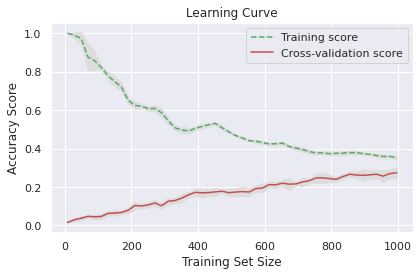

-----------------------------------------------------------------------------------------------------
Confusion matrix of training data:


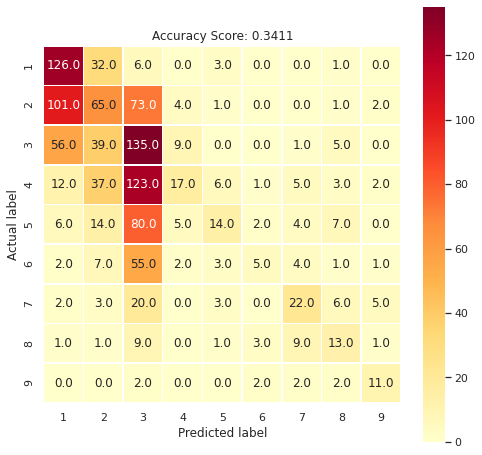

-----------------------------------------------------------------------------------------------------
Classification report with precision, recall, F1-score of each class:
              precision    recall  f1-score   support

           1       0.41      0.75      0.53       168
           2       0.33      0.26      0.29       247
           3       0.27      0.55      0.36       245
           4       0.46      0.08      0.14       206
           5       0.45      0.11      0.17       132
           6       0.38      0.06      0.11        80
           7       0.47      0.36      0.41        61
           8       0.33      0.34      0.34        38
           9       0.50      0.58      0.54        19

    accuracy                           0.34      1196
   macro avg       0.40      0.34      0.32      1196
weighted avg       0.38      0.34      0.30      1196



In [79]:
train_predictions,test_predictions,score = prediction(trainMovie_df_new,Category_label,testMovie_df_new,dt(criterion="entropy",max_depth=6,max_leaf_nodes=30),6)

Inference: After adding the new columns extracted using "board_review_rating" and running decision tree on the training dataset, keeping the k value to be 6 for cross-val score and decreasing the max_depth to 6 and max_leaves node to 30, model is gving a training accuracy of 34% and cross-validation accuracy of 28%. So as we are decreasing the size of our model using the model parameters, I am observing that training score is approaching towards cross-val score.

### Prediction using Random Forest on Model 2.0

Cross-validation Accuracy: 0.28 (+/- 0.03)
-----------------------------------------------------------------------------------------------------
test category labels:
[3 7 4 4 9 7 5 8 5 8 3 3 4 5 3 3 4 9 3 3 4 4 2 3 4 4 3 4 4 4 1 5 3 3 3 2 1
 3 2 3 4 3 4 1 3 1 1 3 1 3 1 3 1 4 2 3 2 3 2 2 2 2 2 2 1 5 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------------------------------------
Learning curve of training score and cross-validated score:


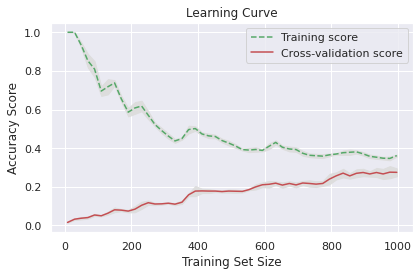

-----------------------------------------------------------------------------------------------------
Confusion matrix of training data:


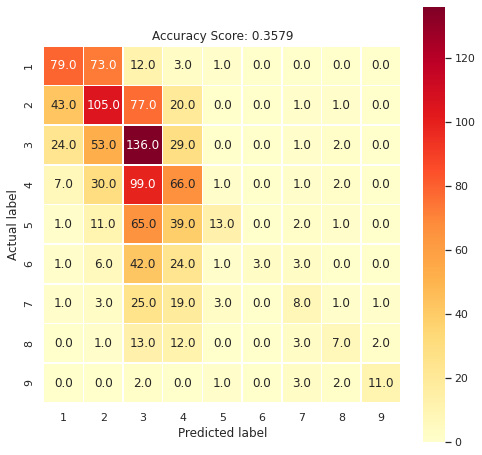

-----------------------------------------------------------------------------------------------------
Classification report with precision, recall, F1-score of each class:
              precision    recall  f1-score   support

           1       0.51      0.47      0.49       168
           2       0.37      0.43      0.40       247
           3       0.29      0.56      0.38       245
           4       0.31      0.32      0.32       206
           5       0.65      0.10      0.17       132
           6       1.00      0.04      0.07        80
           7       0.36      0.13      0.19        61
           8       0.44      0.18      0.26        38
           9       0.79      0.58      0.67        19

    accuracy                           0.36      1196
   macro avg       0.52      0.31      0.33      1196
weighted avg       0.44      0.36      0.34      1196



In [81]:
train_predictions,test_predictions,score = prediction(trainMovie_df_new,Category_label,testMovie_df_new,RF(criterion="entropy", max_depth=6, max_leaf_nodes=10),6)

In the above random forest model, the max_depth has been set to 6 as increasing or decreasing than this value is decreasing the cross-val score. The max_leaf_node is kept to be 10 for the best scores and smaller tree and a k-value to 6. After setting these hyper-parameters, I am getting a cross-validation accuracy of 28% and training accuracy of 35.79%

### Prediction using AdaBoost on Model 2.0

Cross-validation Accuracy: 0.29 (+/- 0.05)
-----------------------------------------------------------------------------------------------------
test category labels:
[3 9 5 4 8 8 5 8 5 8 3 3 7 5 3 3 7 8 3 3 4 3 1 4 4 4 4 5 3 3 1 9 3 3 3 1 1
 3 3 3 4 3 4 1 3 1 1 3 1 3 1 3 1 3 1 3 1 3 3 3 1 2 1 1 1 4 1 1 1 1 1 1 1 1
 6 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------------------------------------
Learning curve of training score and cross-validated score:


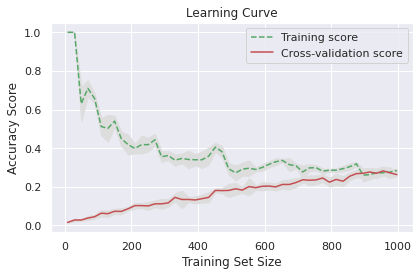

-----------------------------------------------------------------------------------------------------
Confusion matrix of training data:


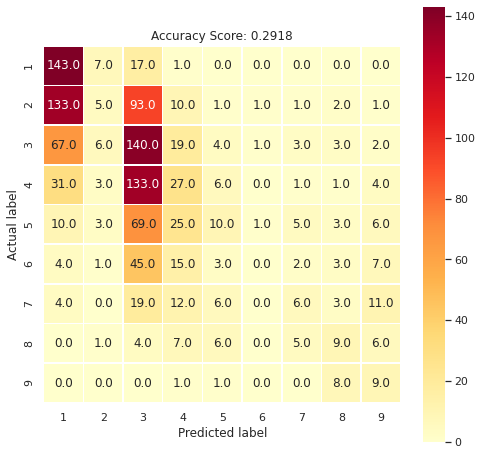

-----------------------------------------------------------------------------------------------------
Classification report with precision, recall, F1-score of each class:
              precision    recall  f1-score   support

           1       0.36      0.85      0.51       168
           2       0.19      0.02      0.04       247
           3       0.27      0.57      0.37       245
           4       0.23      0.13      0.17       206
           5       0.27      0.08      0.12       132
           6       0.00      0.00      0.00        80
           7       0.26      0.10      0.14        61
           8       0.28      0.24      0.26        38
           9       0.20      0.47      0.28        19

    accuracy                           0.29      1196
   macro avg       0.23      0.27      0.21      1196
weighted avg       0.24      0.29      0.22      1196



In [82]:
train_predictions_ada,test_predictions_ada,score_ada = prediction(trainMovie_df_new,Category_label,testMovie_df_new,ab(n_estimators=30,random_state=42),10)

This Adaboost model has given the best performance so far with hyper-parameters n_estimators to be 30 and k fold value to be 10. It is giving a  cross-validation score of 29% and training score of 29.1% which is almost the same. Since Ada-boost is one of ensemble boosting classifier that minimizes overfitting. **I will be using this result in my scoring sheet and as my final classification model.**  Adaboost is more consistent with train and test as we can observe from the cross-validation score.

In [83]:
#Using above model for reporting scores in the Scoring_sheet:
Scoring_df= testMovie_df.loc[:,['id']].copy()
Scoring_df["predicted_category"] = test_predictions_ada

with pd.ExcelWriter('/content/Scoring_Sheet_with_prediction.xlsx') as writer:  
    Scoring_df.to_excel(writer, sheet_name='Predictions')

In [84]:
Scoring_df

,id,predicted_category
0,7970115,3
1,174540115,9
2,149080115,5
3,136020115,4
4,53500115,8
...,...,...
86,169020115,1
87,174110115,1
88,169760115,1
89,175970115,1
